# Autoencoders
# V. Image Retrieval 🕵️


Давайте представим, что весь наш тренировочный датасет — это большая база данных людей. Пусть мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Берем наш VAE, кодируем картинку в латентное представление и ищем среди латентных представлений лиц нашей базы самые ближайшие.

План:

1. Получить латентные представления всех лиц тренировочного датасета
2. Обучить на них NearestNeighbors `(sklearn.neighbors.NearestNeighbors)`
3. Взять картинку из тестового датасета, с помощью VAE получить ее латентный вектор
4. Найти с помощью обученного NearestNeighbors ближайшие из латентных представлений тренировочной базы
5. Найти лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализировать!

## Содержание

- [Подготовка окружения](#environment)

- [Подготовка данных](#data)
    
- [Архитектура модели](#architecture_vaer)

- [Обучение](#train_vaer)

    - [Функция потерь](#loss_vaer)

    - [Функция для обучения VAER](#train_vaer_func)

    - [Обучение VAER](#vaer_train)

- [Поиск похожих лиц](#search_faces)

<a id='environment'></a>
## Подготовка окружения

Импортируем необходимые библиотеки

In [ ]:
import warnings
from IPython.display import clear_output
from tqdm import tqdm
from time import time
import seaborn as sns
import os
import pickle
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchsummary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

import skimage.io
from skimage.transform import resize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import patheffects as path_effects
%matplotlib inline

sns.set(style="whitegrid", font_scale=1.2)


warnings.filterwarnings(action='ignore', category=DeprecationWarning)

[Reproducibility (Pytorch):](https://pytorch.org/docs/stable/notes/randomness.html)

In [ ]:
def set_seed(seed):
    """Установить зерно генераторов случайных чисел"""

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


def seed_worker(worker_id):
    """Воспроизводимость DataLoader'a (см. ссылку выше)"""

    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


set_seed(42)

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [ ]:
!nvidia-smi

Fri Jan  7 22:07:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    30W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Далее будем сохранять лучшие модели

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

DATA_DIR = '/content/gdrive/MyDrive/autoencoders/weights'

Mounted at /content/gdrive/


<a id='data'></a>
## Подготовка данных

In [ ]:
def fetch_dataset(attrs_name="lfw_attributes.txt",
                  images_name="lfw-deepfunneled",
                  dx=80, dy=80,
                  dimx=64, dimy=64
                  ):

    # Скачать, если не существует
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system(
            "wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system(
            "wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    # Считываем атрибуты
    df_attrs = pd.read_csv("lfw_attributes.txt", sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(
        df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])

    # Считываем фотографии
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append(
                    {'person': person_id, 'imagenum': photo_number, 'photo_path': fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)

    # Mass-merge
    df = pd.merge(df_attrs, photo_ids, on=('person', 'imagenum'))

    assert len(df) == len(df_attrs), "lost some data when merging dataframes"

    # print(df.shape)
    # Предобработка изображений
    all_photos = df['photo_path'].apply(skimage.io.imread)\
        .apply(lambda img: img[dy:-dy, dx:-dx])\
        .apply(lambda img: resize(img, [dimx, dimy]))

    all_photos = np.stack(all_photos.values).astype('float32')
    all_attrs = df.drop(["photo_path", "person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [ ]:
# Загрузим данные
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
# Разделим на обучение и валидацию
X_train, X_val, atts_train, attrs_val = train_test_split(data,
                                                         attrs,
                                                         train_size=0.9,
                                                         shuffle=True,
                                                         random_state=42
                                                         )

# Приведем данные к форме (BatchSize x C x H x W)
X_train_CHW = np.rollaxis(X_train, 3, 1)
X_val_CHW = np.rollaxis(X_val, 3, 1)

# Создадим dataloader'ы
train_loader = DataLoader(X_train_CHW, batch_size=64, shuffle=True)
val_loader = DataLoader(X_val_CHW, batch_size=64, shuffle=False)

<a id='architecture_vaer'></a>
## Архитектура модели

In [ ]:
dim_vaer = 512      # Размерность латентного пространства


class VAER(nn.Module):
    """Variational autoencoder for retrieval"""

    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            # Feature Extractor
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.Flatten(),

            # FC
            nn.Linear(in_features=128*8*8, out_features=128*8),
            nn.ReLU(True),
            nn.Linear(in_features=128*8, out_features=dim_vaer*2)
        )

        self.decoder = nn.Sequential(
            # FC
            nn.Linear(in_features=dim_vaer, out_features=128*8),
            nn.ReLU(True),
            nn.Linear(in_features=128*8, out_features=128*8*8),

            nn.Unflatten(1, unflattened_size=(128, 8, 8)),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Feature Extractor
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 3, 3, padding=1)
        )

    def encode(self, x):
        """Forward проход энкодера.
        Возвращаемые переменные -- mu и logsigma
        """

        x = self.encoder(x)
        mu, logsigma = torch.split(x, dim_vaer, dim=1)

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # Засемплируем латентный вектор из нормального распределения с
            # параметрами mu и sigma
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
        else:
            # На инференсе возвращаем не случайный вектор из нормального
            # распределения, а центральный -- mu.
            # На инференсе выход автоэнкодера должен быть детерминирован.
            sample = mu

        return sample

    def decode(self, z, eps=1e-7):
        """Forward проход декодера.
        В качестве возвращаемой переменной -- reconstruction
        """

        x = self.decoder(z)
        reconstruction = torch.clamp(x.sigmoid(), min=eps, max=1-eps)

        return reconstruction

    def forward(self, x):
        """Forward проход автоэнкодера.
        В качестве возвращаемых переменных -- mu, logsigma и reconstruction
        """

        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

In [ ]:
vaer = VAER().to(DEVICE)

# Архитектура получившегося VAER
torchsummary.summary(vaer, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 16, 16]         131,200
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8            [-1, 128, 8, 8]         262,272
       BatchNorm2d-9            [-1, 128, 8, 8]             256
             ReLU-10            [-1, 128, 8, 8]               0
          Flatten-11                 [-1, 8192]               0
           Linear-12                 [-1, 1024]       8,389,632
             ReLU-13                 [-1, 1024]               0
           Linear-14                 [-

<a id='train_vaer'></a>
## Обучение

<a id='loss_vaer'></a>
### Функция потерь

В качестве функции потерь будем использовать сумму KL-дивергенции и кросс-энтропии, которую мы определили [ранее](https://github.com/ivantipow/Autoencoders/blob/main/2_Variational_Autoencoder.ipynb):

In [ ]:
def KL_divergence(mu, logsigma):
    """Дивергенция Кульбака — Лейблера.
    Часть функции потерь, которая отвечает за "близость" латентных 
    представлений разных цифр
    """

    loss = torch.sum(mu.pow(2) + logsigma.exp() -
                     1 - logsigma) / (2*mu.shape[0])

    return loss


def log_likelihood(x, reconstruction):
    """ Логарифм правдоподобия.
    Часть функции потерь, которая отвечает за качество реконструкции 
    (как mse в обычном autoencoder, см. первый блокнот)
    """

    batch_size = x.shape[0]
    loss = nn.BCELoss(reduction='sum')

    return loss(reconstruction, x) / batch_size


def loss_vaer(x, mu, logsigma, reconstruction):
    """Общий лосс"""

    loss = KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

    return loss

<a id='train_vaer_func'></a>
### Функция для обучения VAER

In [ ]:
def train_model(train_loader, val_loader, model, model_name, epochs,
                criterion, optimizer, scheduler):
    """Обучить Autoencoder"""

    best_loss = 9999999

    since = time()

    # Loss per batch
    train_losses = []
    test_losses = []

    for epoch in tqdm(range(epochs)):
        set_seed(42 + 3 * epoch)

        # Train-phase
        model.train()
        train_losses_per_epoch = []

        for x_batch in train_loader:

            x_batch = x_batch.to(DEVICE)

            mu, logsigma, reconstruction = model(x_batch)
            loss = criterion(x_batch, mu, logsigma, reconstruction)

            loss.backward()
            optimizer.step()

            train_losses_per_epoch.append(loss.detach().cpu().item())

            optimizer.zero_grad()

        train_losses.append(np.mean(train_losses_per_epoch))

        scheduler.step()

        # Test-phase
        model.eval()
        test_losses_per_epoch = []

        with torch.no_grad():
            for x_batch in val_loader:

                x_batch = x_batch.to(DEVICE)

                mu, logsigma, reconstruction = model(x_batch)
                loss = criterion(x_batch, mu, logsigma, reconstruction)

                test_losses_per_epoch.append(loss.detach().cpu().item())

        test_losses.append(np.mean(test_losses_per_epoch))

        # Сохранить лучшую модель
        if best_loss > test_losses[-1]:
            best_loss = test_losses[-1]
            best_t_loss = train_losses[-1]
            torch.save(model.state_dict(),
                       os.path.join(DATA_DIR, 'best_' + model_name + '.pth'))
            best_epoch = epoch + 1
            best_time = time() - since

        # Сохранить текущую модель
        torch.save(model.state_dict(),
                   os.path.join(DATA_DIR, 'last_' + model_name + '.pth'))

        # Visualize tools
        clear_output(wait=True)

        original = x_batch.cpu().numpy()
        reconstuct = reconstruction.cpu().numpy()

        plt.figure(figsize=(10, 8))
        for i in range(6):
            plt.subplot(4, 6, i+1)
            plt.axis("off")
            plt.imshow(np.rollaxis(original[i], 0, 3))
            plt.title('original')

            plt.subplot(4, 6, i+7)
            plt.axis("off")
            plt.imshow(np.rollaxis(reconstuct[i], 0, 3))
            plt.title('reconstruct')

        plt.subplot(2, 1, 2)
        plt.plot(train_losses, label="train_loss")
        plt.plot(test_losses, label="val_loss")
        plt.legend(loc='upper right')
        plt.xlabel("epochs")
        plt.ylabel("loss")

        plt.suptitle(f'{epoch + 1} / {epochs} - train loss: {train_losses[-1]:.4f} - val loss: {test_losses[-1]:.4f}',
                     fontsize=18)

        plt.show()

    # Final
    print(
        f'Training is done! Best epoch {best_epoch}, best time {best_time}, best val loss {best_loss}, best train loss {best_t_loss}')

    # Загрузить лучшие веса модели
    model.load_state_dict(torch.load(
        os.path.join(DATA_DIR, 'best_' + model_name + '.pth')))

    return model

<a id='vaer_train'></a>
### Обучение VAER

In [ ]:
criterion = loss_vaer

vaer = VAER().to(DEVICE)

optimizer = optim.AdamW(params=vaer.parameters())

scheduler = lr_scheduler.StepLR(optimizer, step_size=43, gamma=0.1)

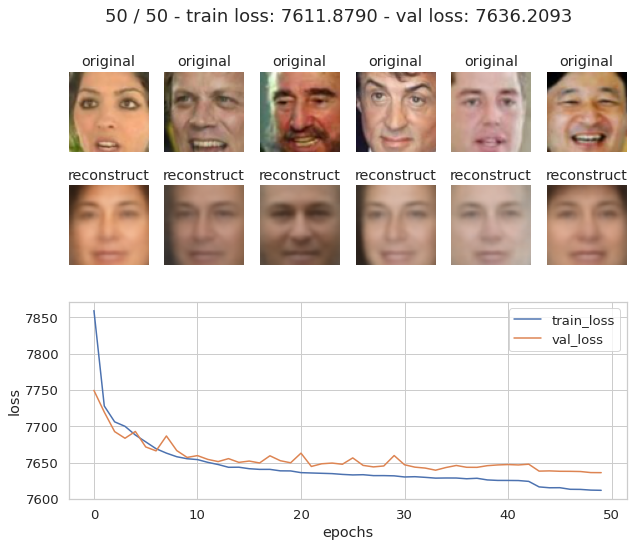

100%|██████████| 50/50 [39:01<00:00, 46.84s/it]

Training is done! Best epoch 50, best time 2339.3934705257416, best val loss 7636.209309895833, best train loss 7611.878956397804


In [ ]:
epochs = 50
vaer = train_model(train_loader, val_loader, vaer, 'vaer',
                   epochs, criterion, optimizer, scheduler)

<a id='search_faces'></a>
## Поиск похожих лиц

In [ ]:
# Загрузим обученный автоэнкодер
vaer = VAER().to(DEVICE)
vaer.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_vaer.pth')))

<All keys matched successfully>

Создадим новый DataLoader. Наша нейронная сеть уже обучена, теперь мы будем только отображать наши изображения в вектора из латентного пространства (без расчета градиентов), потому размер батчей зададим побольше. Также мы уберем перемешивание, чтобы могли в дальнейшем найти ближайших соседей по индексам.

In [ ]:
# Создадим DataLoader
train_loader = DataLoader(X_train_CHW,
                          batch_size=500,
                          shuffle=False)

Получим латентные представления всех лиц тренировочного датасета

In [ ]:
codes = np.zeros((1, dim_vaer))

with torch.no_grad():
    vaer.eval()
    for inputs in train_loader:
        inputs = inputs.to(DEVICE)
        latent, _ = vaer.encode(inputs)
        codes = np.concatenate((codes, latent.cpu().numpy()))

codes = np.delete(codes, 0, axis=0)

print('Размеры полученных латентных векторов', codes.shape)

# Сохраним codes
with open(os.path.join(DATA_DIR, 'codes_latent.pickle'), 'wb') as f:
    pickle.dump(codes, f)

Размеры полученных латентных векторов (11828, 512)


Для поиска наиболее похожих лиц будем использовать метод ближайших соседей

In [ ]:
neighbor = NearestNeighbors(metric='euclidean')

# Обучим NearestNeighbors на наших латентных векторах
neighbor.fit(codes)

with open(os.path.join(DATA_DIR, 'neighbors_vaer.pickle'), 'wb') as f:
    pickle.dump(neighbor, f)

In [ ]:
def get_similar(image, n_neighbors=5):
    """ Взять изображение image, получить его латентное представление.
    Найти в латентном пространстве n_neighbors ближайших лиц.
    Вернуть восстановленные через декодер эти лица, исходный их вид
    и расстояние до них, а также image после прохода через автоэнкодер.
    """

    # Преобразуем изображение лица, которому будем искать схожих
    image_CHW = np.rollaxis(image[np.newaxis], 3, 1)
    image_tensor = torch.FloatTensor(image_CHW).to(DEVICE)

    # Получим вектор в латентном пространстве для лица, схожие
    # к которому мы будем искать
    vaer.eval()
    with torch.no_grad():
        code, _ = vaer.encode(image_tensor)

    # Получим расстояния до ближайших соседей (в латентном пространстве)
    # и их индексы
    (distances,), (idx,) = neighbor.kneighbors(code.cpu().numpy(),
                                               n_neighbors=n_neighbors)

    # Исходные изображения ближайших соседей
    originals = X_train_CHW[idx]

    # Латентные вектора ближайших соседей
    codes_tensor = torch.cuda.FloatTensor(codes[idx])

    # Исходное лицо и "ближайшие" лица после прохода через декодер
    vaer.eval()
    with torch.no_grad():
        code_reconstuct = vaer.decode(code)
        reconstuct = vaer.decode(codes_tensor)

    return (distances, reconstuct.cpu().numpy(),
            originals, code_reconstuct.cpu().numpy())

In [ ]:
def show_similar(image, n_neighbors=5):
    """ Визуализировать исходное лицо image и n_neighbors наиболее похожих 
    на него лиц. Также для всех этих лиц показать, как они выглядят
    после прохода через автоэнкодер.
    """

    distances, reconstructs, originals, code_rec = get_similar(image,
                                                               n_neighbors=n_neighbors)

    # Визуализируем
    plt.figure(figsize=(15, 5))

    plt.subplot(2, n_neighbors + 1, 1)
    plt.axis("off")
    plt.imshow(image)
    plt.title('Original image')

    plt.subplot(2, n_neighbors + 1, n_neighbors + 2)
    plt.axis("off")
    plt.imshow(code_rec[0].transpose([1, 2, 0]))
    plt.title('Distance = 0')

    for i in range(n_neighbors):
        plt.subplot(2, n_neighbors + 1, i + 2)
        plt.axis("off")
        plt.imshow(originals[i].transpose([1, 2, 0]))
        plt.title('Neighbor №%d' % (i+1))

        plt.subplot(2, n_neighbors + 1, i + 3 + n_neighbors)
        plt.axis("off")
        plt.imshow(reconstructs[i].transpose([1, 2, 0]))
        plt.title("Distance = %.3f" % distances[i])

    plt.show()

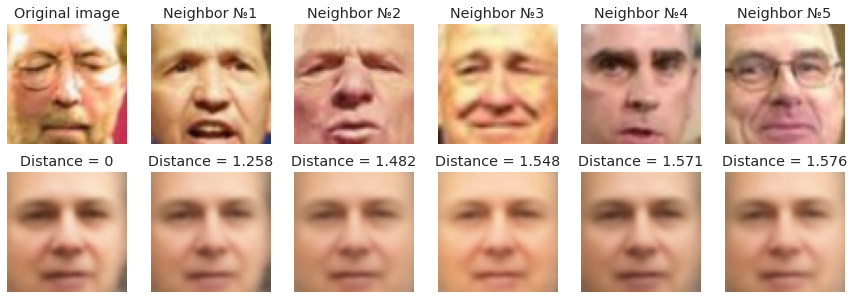

In [ ]:
show_similar(X_val[8], n_neighbors=5)